In [1]:
from __future__ import division
import json, os
from collections import defaultdict

In [2]:
from utils import *
%load_ext autoreload
%autoreload 2

### goal: 
(1) subset to entities with one mention only 
(2) look at false positives
(3) look at false negatives 

See how these differ with greedy, 10 Monte Carlo samples and 100 Monte Carlo samples. 

In [3]:
#get indexes for all mentions 
mode2name2idxs = {m: defaultdict(list) for m in ['train', 'test']}
for mode in ['train', 'test']:
    for i, line in enumerate(open('/home/kkeith/newsevents/data/'+mode+'.json')):
        dd = json.loads(line)
        name = dd['name']
        mode2name2idxs[mode][name].append(i)
    print i

132832
68924


In [4]:
#find all one-mention names 
mode2onement = {m: set() for m in ['train', 'test']}
for mode in ['train', 'test']:
    for name, idx_list in mode2name2idxs[mode].iteritems():
        numments = len(idx_list)
        if numments == 1: 
            mode2onement[mode].add(name)

#### how many of the 1ment names are positives? 

In [5]:
#1. load FE names 
fe_all_filename = "/home/kkeith/policefatalities_emnlp2017/data/gold/fatalencs/fe-all.json"
all_gold = set([json.loads(line)['name'] for line in open(fe_all_filename)])
print len(all_gold)

17870


In [22]:
testents, histents = get_gold()
print len(testents), len(histents)

LOADING fe
FATAL ENCOUNTERS: num in test set 463, num historical 19349
463 19349


In [24]:
# how many of 1 ment names are positives 
mode2POSonement = {m: set() for m in ['train', 'test']}
for mode in ['test']:
    print '===', mode
    print '   total ents= ', len(mode2name2idxs[mode].keys())
    print '   ents with 1ment= ', len(mode2onement[mode])
    #pos = mode2onement[mode] & all_gold #that is not excluding historical... 
    #throw away historical 
    pos = mode2onement[mode] & testents
    mode2POSonement[mode] = pos 
    print '   ents with 1ment POS= ', len(pos) 
    print ''

=== test
   total ents=  24550
   ents with 1ment=  16601
   ents with 1ment POS=  71



In [25]:
#get all the indexes of 1ment pos entities: 
mode2posidxes = {m: [] for m in ['train', 'test']}
for mode in ['train', 'test']:
    for name in mode2POSonement[mode]:
        mode2posidxes[mode] += mode2name2idxs[mode][name]

#make sure same number of mentions as the same number of pos 1-ment names
for mode in ['train', 'test']:
    mode2posidxes[mode] = sorted(mode2posidxes[mode])
    print mode
    print len(mode2posidxes[mode])
    print ''

train
0

test
71



### rule-based 
Look at greedy rule-based false positives and false negatives. 

In [26]:
fnames = ['dicts_allsent_greedy.out', 'dicts_allsent_10samp.out', 'dicts_allsent_100samp.out']
labels = ['greedy', '10samp', '100samp']
pos_names = mode2POSonement['test']

In [27]:
#GREEDY FALSE NEGATIVES (only at test time)
samp2fn = defaultdict(int)
samp2fn_text = defaultdict(list)

for ff, label in zip(fnames, labels):
    for line in open(ff, 'r'):
        dd = json.loads(line)
        if dd['name'] not in pos_names: continue 
        if dd['weight'] == 0.0:
            samp2fn[label] += 1
            samp2fn_text[label].append(dd['sent_alter'])

In [29]:
print 'TOTAL POS 1MENT=', len(pos_names)
print '(false negatives being a hard threshold weight=0.0)'
print ''
for label in labels:
    fn = samp2fn[label] 
    print label+' num false negatives=', fn
    print '  '+str(fn/len(pos_names)*100)+'%'
    print ''

TOTAL POS 1MENT= 71
(false negatives being a hard threshold weight=0.0)

greedy num false negatives= 62
  87.323943662%

10samp num false negatives= 57
  80.2816901408%

100samp num false negatives= 51
  71.8309859155%



In [30]:
ttl2wtcts_fn = {}
for ff, label in zip(fnames, labels):
    weight_counts = Counter()
    for line in open(ff, 'r'):
        dd = json.loads(line)
        if dd['name'] not in pos_names: continue 
        weight_counts[dd['weight']] += 1
    ttl2wtcts_fn[label] = weight_counts
    print label, weight_counts, '\n'

greedy Counter({0.0: 62, 1.0: 9}) 

10samp Counter({0.0: 57, 1.0: 5, 0.1: 2, 0.3: 2, 0.7: 2, 0.2: 1, 0.6: 1, 0.9: 1}) 

100samp Counter({0.0: 51, 0.01: 4, 0.66: 2, 1.0: 1, 0.97: 1, 0.83: 1, 0.05: 1, 0.26: 1, 0.64: 1, 0.88: 1, 0.02: 1, 0.48: 1, 0.03: 1, 0.19: 1, 0.04: 1, 0.98: 1, 0.56: 1}) 



FALSE NEGATIVES--10 MC SAMPLES


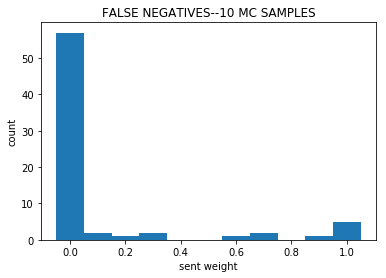

In [34]:
#10 sample
title = 'FALSE NEGATIVES--10 MC SAMPLES'
print title
a = ttl2wtcts_fn['10samp']
a = dict(a)
# print '0.0:', a[0.0]
# print 'remove 0.0 b/c then cant see rest of histogram'
# del a[0.0]
plt.bar(a.keys(), a.values(), 0.1)
plt.title(title)
plt.xlabel('sent weight')
plt.ylabel('count')
plt.show()

FALSE NEGATIVES--100 MC SAMPLES


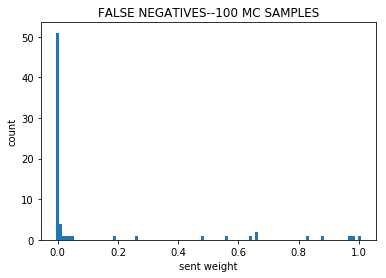

In [36]:
#100 sample
title = 'FALSE NEGATIVES--100 MC SAMPLES'
print title
a = ttl2wtcts_fn['100samp'].copy()
a = dict(a)
# print '0.0:', a[0.0]
# print 'remove 0.0 b/c then cant see rest of histogram'
# del a[0.0]
plt.bar(a.keys(), a.values(), 0.01)
plt.title(title)
plt.xlabel('sent weight')
plt.ylabel('count')
plt.show()

## false positives

In [41]:
# how many of 1 ment names are NEGATIVES 
NEGonement = set()
for mode in ['test']:
    print '===', mode
    print '   total ents= ', len(mode2name2idxs[mode].keys())
    print '   ents with 1ment= ', len(mode2onement[mode])
    #NEGonement = mode2onement[mode] - all_gold
    NEGonement = mode2onement[mode] - testents
    print '   ents with 1ment NEG= ', len(NEGonement) 
    print '(sanity check) positives=', len(mode2onement[mode]) - len(NEGonement)
    print ''

=== test
   total ents=  24550
   ents with 1ment=  16601
   ents with 1ment NEG=  16530
(sanity check) positives= 71



In [42]:
#FALSE POSITIVES (only at test time)
samp2fp = defaultdict(int)
samp2fp_text = defaultdict(list)

for ff, label in zip(fnames, labels):
    for line in open(ff, 'r'):
        dd = json.loads(line)
        if dd['name'] not in NEGonement: continue 
        if dd['weight'] == 1.0:
            samp2fp[label] += 1
            samp2fp_text[label].append(dd['sent_alter'])

In [45]:
print 'TOTAL NEG 1MENT=', len(NEGonement)
print '(false positives being a hard threshold weight=1.0)'
print ''
for label in labels:
    fp = samp2fp[label] 
    print label+' num false positives=', fp
    print '  '+str(fp/len(NEGonement)*100)+'%'
    print ''

TOTAL NEG 1MENT= 16530
(false positives being a hard threshold weight=1.0)

greedy num false positives= 242
  1.46400483969%

10samp num false positives= 83
  0.502117362371%

100samp num false positives= 13
  0.0786448880823%



In [46]:
ttl2wtcts_fp = {}
for ff, label in zip(fnames, labels):
    weight_counts = Counter()
    for line in open(ff, 'r'):
        dd = json.loads(line)
        if dd['name'] not in NEGonement: continue 
        weight_counts[dd['weight']] += 1
    ttl2wtcts_fp[label] = weight_counts
    print label, weight_counts, '\n'

greedy Counter({0.0: 16288, 1.0: 242}) 

10samp Counter({0.0: 16145, 1.0: 83, 0.1: 83, 0.8: 41, 0.9: 40, 0.2: 26, 0.6: 25, 0.3: 24, 0.4: 23, 0.7: 21, 0.5: 19}) 

100samp Counter({0.0: 15915, 0.01: 135, 0.02: 59, 0.03: 32, 0.04: 29, 0.98: 18, 0.97: 14, 0.99: 14, 1.0: 13, 0.05: 13, 0.06: 12, 0.96: 10, 0.07: 9, 0.94: 9, 0.95: 8, 0.08: 8, 0.12: 7, 0.85: 7, 0.18: 7, 0.26: 6, 0.88: 6, 0.87: 6, 0.89: 5, 0.34: 5, 0.14: 5, 0.13: 5, 0.62: 5, 0.93: 5, 0.31: 5, 0.52: 5, 0.48: 5, 0.25: 4, 0.9: 4, 0.56: 4, 0.09: 4, 0.83: 4, 0.42: 4, 0.91: 4, 0.82: 4, 0.77: 4, 0.7: 4, 0.72: 4, 0.65: 4, 0.47: 3, 0.67: 3, 0.8: 3, 0.71: 3, 0.86: 3, 0.55: 3, 0.92: 3, 0.78: 3, 0.64: 3, 0.68: 3, 0.17: 3, 0.58: 3, 0.81: 3, 0.79: 3, 0.19: 2, 0.75: 2, 0.24: 2, 0.59: 2, 0.2: 2, 0.1: 2, 0.76: 2, 0.41: 2, 0.6: 2, 0.15: 2, 0.11: 2, 0.69: 2, 0.45: 2, 0.44: 2, 0.23: 2, 0.43: 2, 0.21: 2, 0.54: 2, 0.16: 2, 0.29: 2, 0.49: 2, 0.32: 2, 0.73: 1, 0.46: 1, 0.22: 1, 0.4: 1, 0.84: 1, 0.61: 1, 0.27: 1, 0.33: 1, 0.53: 1, 0.63: 1, 0.39: 1, 0.74

FALSE POSITIVES--10 MC SAMPLES
0.0: 16145
remove 0.0 b/c then cant see rest of histogram


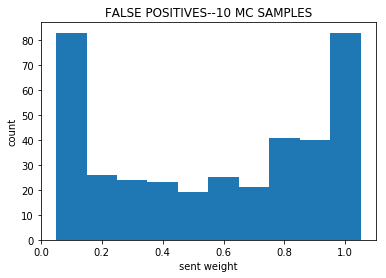

In [47]:
#10 sample
title = 'FALSE POSITIVES--10 MC SAMPLES'
print title
a = ttl2wtcts_fp['10samp']
a = dict(a)
print '0.0:', a[0.0]
print 'remove 0.0 b/c then cant see rest of histogram'
del a[0.0]
plt.bar(a.keys(), a.values(), 0.1)
plt.title(title)
plt.xlabel('sent weight')
plt.ylabel('count')
plt.show()

FALSE POSITIVES--100 MC SAMPLES
0.0: 15915
remove 0.0 b/c then cant see rest of histogram


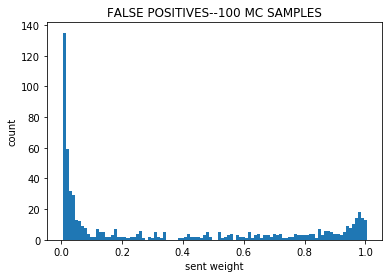

In [48]:
#100 sample
title = 'FALSE POSITIVES--100 MC SAMPLES'
print title
a = ttl2wtcts_fp['100samp'].copy()
a = dict(a)
print '0.0:', a[0.0]
print 'remove 0.0 b/c then cant see rest of histogram'
del a[0.0]
plt.bar(a.keys(), a.values(), 0.01)
plt.title(title)
plt.xlabel('sent weight')
plt.ylabel('count')
plt.show()